# Predicting the noise level of noisy FashionMNIST images

> Predicting the noise level of noisy FashionMNIST images


- skip_showdoc: true
- skip_exec: true

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.

## Imports

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from fastAIcourse.datasets import *
from fastAIcourse.conv import *
from fastAIcourse.learner import *
from fastAIcourse.activations import *
from fastAIcourse.init import *
from fastAIcourse.sgd import *
from fastAIcourse.resnet import *
from fastAIcourse.augment import *
from fastAIcourse.accel import *
from fastAIcourse.fid import ImageEval

In [ ]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Load dataset

Use 28x28 images, high batch size.

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

In [ ]:
def noisify(x0):
    device = x0.device
    al_t = torch.rand((len(x0), 1, 1, 1), device=device)
    ε = torch.randn(x0.shape, device=device)
    xt = al_t.sqrt()*x0 + (1-al_t).sqrt()*ε
    return xt,al_t.squeeze().logit()

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
dl = dls.train
xt,amt = next(iter(dl))

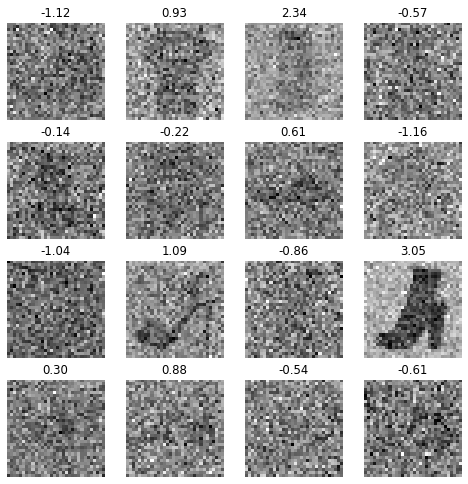

In [ ]:
titles = [f'{o:.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

In [ ]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): return torch.full((len(x),), 0.5)

In [ ]:
metrics = MetricsCB()

In [ ]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=metrics)
learn.fit(1, train=False)

{'loss': '3.567', 'epoch': 0, 'train': 'eval'}


In [ ]:
F.mse_loss(amt,torch.full(amt.shape, 0.5))

tensor(3.7227)

In [ ]:
def flat_mse(x,y): return F.mse_loss(x.flatten(), y.flatten())

In [ ]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Dropout(0.2), nn.Linear(nfs[-1], 1, bias=False)]
    return nn.Sequential(*layers)

In [ ]:
opt_func = partial(optim.Adam, eps=1e-5)
epochs = 20
lr = 1e-2

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.320,0,train
0.228,0,eval
0.173,1,train
0.146,1,eval


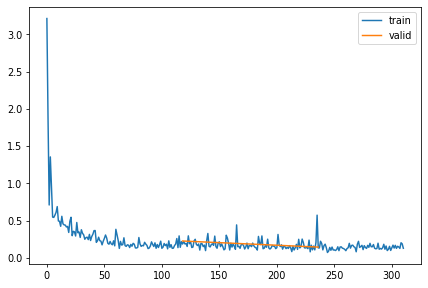

KeyboardInterrupt: 

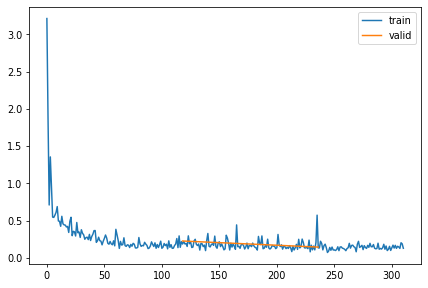

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/noisepred_sig.pkl')
tmodel = learn.model
tmodel = torch.load('models/noisepred_sig.pkl').cuda()

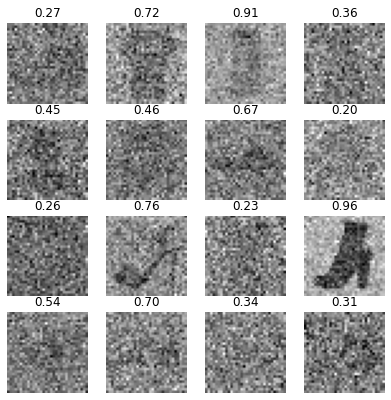

In [ ]:
with torch.no_grad(): a = to_cpu(tmodel(xt.cuda()).squeeze())
titles = [f'{o.sigmoid():.2f}' for o in a[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

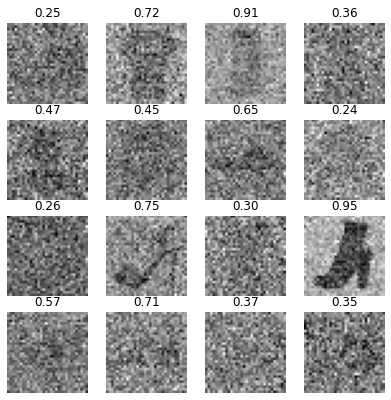

In [ ]:
titles = [f'{o.sigmoid():.2f}' for o in amt[:16]]
show_images(xt[:16], imsize=1.7, titles=titles)

## No-time model

In [ ]:
from diffusers import UNet2DModel
from torch.utils.data import DataLoader,default_collate

In [ ]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

In [ ]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand((n,)).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape).to(x0)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return xt, ε

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(x,0).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
lr = 4e-3
epochs = 25
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.395,0,train
0.073,0,eval
0.059,1,train
0.055,1,eval
0.050,2,train
0.047,2,eval
0.047,3,train
0.046,3,eval
0.046,4,train
0.046,4,eval


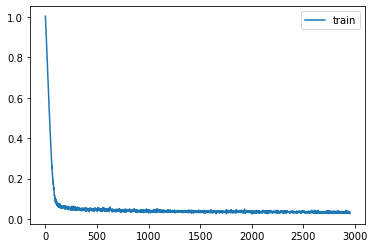

In [ ]:
learn.fit(epochs)

In [ ]:
# torch.save(learn.model, 'models/fashion_no-t.pkl')
model = learn.model = torch.load('models/fashion_no-t.pkl').cuda()

## Sampling

In [ ]:
sz = (2048,1,32,32)

In [ ]:
sz = (512,1,32,32)

In [ ]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
#     sig *= 0.5
    with torch.no_grad(): a = tmodel(x_t)[...,None,None].sigmoid()
    med = a.median()
    a = a.clamp(med/2,med*2)
#     t = inv_abar(a)
#     t = inv_abar(med)
#     at1 = abar(t-10, 1000) if t>=1 else torch.tensor(1)
#     sig = (((1-at1)/(1-med)).sqrt() * (1-med/at1).sqrt()) * eta
    x_0_hat = ((x_t-(1-a).sqrt()*noise) / a.sqrt()).clamp(-2,2)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
#     print(*to_cpu((a.min(), a.max(), a.median(),x_t.min(),x_0_hat.min(),bbar_t1)), sig**2)
    return x_0_hat,x_t

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    with torch.no_grad(): a = tmodel(x_t)[...,None,None].sigmoid()
    med = a.median()
    a = a.clamp(med/2,med*2)
    x_0_hat = ((x_t-(1-a).sqrt()*noise) / a.sqrt()).clamp(-2,2)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-0.5,0.5)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat

In [ ]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model(x_t)
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
#         print(abar_t,abar_t1,x_t.min(),x_t.max())
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [ ]:
set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)

In [ ]:
# classic ddim eta 1.0
ie.fid(s),ie.kid(s),s.shape

(22.329004136195408, 0.11790715157985687, torch.Size([2048, 1, 32, 32]))

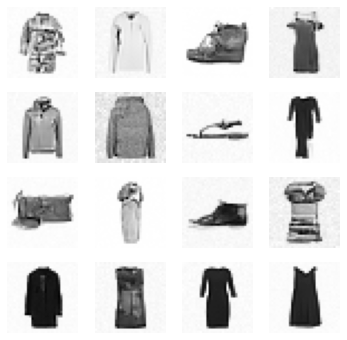

In [ ]:
show_images(s[:16], imsize=1.5)

In [ ]:
# model-t eta 1.0
ie.fid(s),ie.kid(s),s.shape

(3.8815142331816332, 0.004408569075167179, torch.Size([2048, 1, 32, 32]))

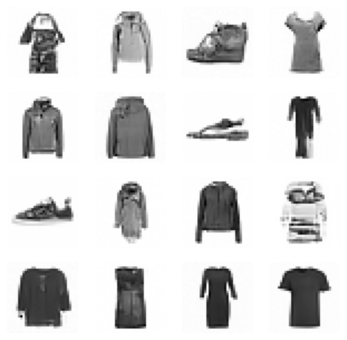

In [ ]:
show_images(s[:16], imsize=1.5)

In [ ]:
# model-t eta 0.5
ie.fid(s),ie.kid(s),s.shape

(4.577682060889174, -0.0011141474824398756, torch.Size([2048, 1, 32, 32]))

In [ ]:
# model-t eta 0
ie.fid(s),ie.kid(s),s.shape

(5.7531284851394275, 0.01766902022063732, torch.Size([2048, 1, 32, 32]))

In [ ]:
# median sig
ie.fid(s),ie.kid(s),s.shape

(4.013061676593566, 0.004139504861086607, torch.Size([2048, 1, 32, 32]))

In [ ]:
# sig *= 0.5
ie.fid(s),ie.kid(s),s.shape

(4.011975098678363, 0.0034716420341283083, torch.Size([2048, 1, 32, 32]))

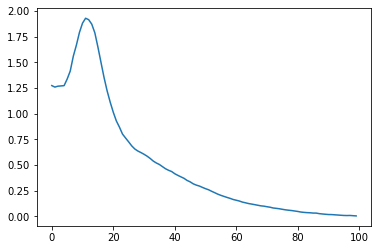

In [ ]:
plt.plot([ie.kid((o*2).clamp(-1,1)) for o in preds]);